<a href="https://colab.research.google.com/github/Haibei1115/Subglacial-Discharge/blob/main/Intrusion_length_vs_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Hydraulic control point analytic calculation
import math
import numpy as np
import matplotlib.pyplot as plt


def compute_x_c(F, S, C):
    """
    Computes the two possible values of x_c from the formula:

      x_c = ln( { (F^(2/3) - S + c) +/- sqrt( (...) ) } / 2 )

    Returns:
      (x_c_plus, x_c_minus)

    If the argument of the log is non-positive, that branch will give an error or a NaN.
    You might need to handle domain checks depending on your parameters.
    """
    # Precompute terms
    f_23 = F**(2/3)  # F^(2/3)
    numerator_base = f_23 - S + C

    # The expression under the sqrt
    inside_sqrt = numerator_base**2 + 4*((f_23 - 1)*(S - 1) + C)

    # Protect against negative inside_sqrt if needed:
    if inside_sqrt < 0:
        # You can decide how to handle no real solutions
        raise ValueError(f"Inside of sqrt is negative ({inside_sqrt}); no real x_c.")

    # Now compute the plus and minus numerators
    root = math.sqrt(inside_sqrt)
    plus_numer = numerator_base + root
    minus_numer = numerator_base - root

    # Each fraction is divided by 2 inside the log
    # Check the sign of each fraction to avoid taking log of a negative/zero
    if plus_numer <= 0:
        x_c_plus = float('nan')  # or handle domain error
    else:
        x_c_plus = math.log(plus_numer / 2)

    if minus_numer <= 0:
        x_c_minus = float('nan')
    else:
        x_c_minus = math.log(minus_numer / 2)

    return x_c_plus, x_c_minus

In [ ]:
## Calculating Perturbation in B.C.

import math
from typing import Tuple, Literal

def k_initial(
    F: float,
    C: float,
    h_c: float,
    h_c_prime: float,
    h_c_double_prime: float,
    root: Literal["plus", "minus"] = "plus",
) -> float:
    """
    Compute the inner‐layer initial slope k that satisfies

        (3/F^{2/3}) k^2 − A1 k + Ax = 0,

    with
        Δ        = h_c − F^{2/3}
        Ax       = C*(−F^{2/3} * h_c_prime) / Δ**2  − h_c_double_prime
        A1       = C*h_c/Δ**2 − (3/F^{2/3})*(1 + C*h_c/Δ)

        k = (F^{2/3}/6) * [ A1 ± sqrt( A1**2 − (12/F^{2/3})*Ax ) ].

    Parameters
    ----------
    F  : Froude number (positive).
    C  : density-ratio parameter.
    h_c, h_c_prime, h_c_double_prime : depth, first and second x-derivatives
         of the prescribed total depth h(x) evaluated at the control point x_c.
    root : choose `"plus"` (default) or `"minus"` branch of the quadratic.

    Returns
    -------
    k : float
        The requested root.  Raises ValueError if the discriminant is negative
        (no real solution) or if Δ = 0.

    Examples
    --------
    >>> k_initial(F=1.5, C=0.2, h_c=3.0,
    ...           h_c_prime=0.10, h_c_double_prime=-0.05)
    -0.0142748762781836
    >>> k_initial(..., root="minus")
    ...
    """
    # Δ = h_c − F^{2/3}
    delta = h_c - F ** (2 / 3)
    if delta == 0.0:
        raise ValueError("Δ = 0 ⇒ control point is ill-defined.")

    # Ax and A1
    Ax = C * (-F ** (2 / 3) * h_c_prime) / delta ** 2 - h_c_double_prime
    A1 = C * h_c / delta ** 2 - (3 / F ** (2 / 3)) * (1 + C * h_c / delta)

    # Discriminant
    disc = A1 ** 2 - (12 / F ** (2 / 3)) * Ax
    if disc < 0:
        raise ValueError("Discriminant < 0 ⇒ k is complex.")

    sqrt_disc = math.sqrt(disc)
    factor = F ** (2 / 3) / 6

    return factor * (A1 + sqrt_disc if root == "plus" else A1 - sqrt_disc)

x_c_plus =  0.11599531763932504
x_c_minus =  nan
k (plus branch)  = 0.12184726742856308
k (minus branch) = -1.2354124489234777


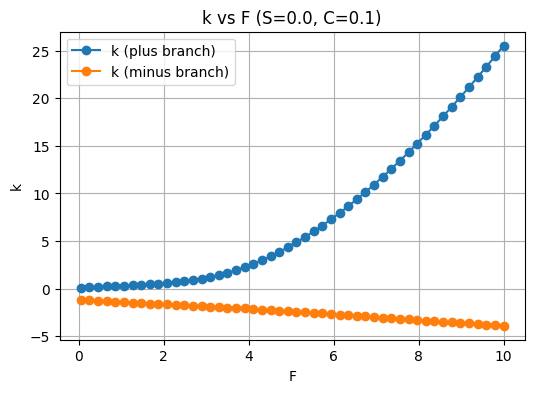

In [ ]:
## Example Calculation of Perturbation in B.C.
import numpy as np


def channel_height(x):
    """
    Prescribed channel shape h(x) = 1 + e^x.
    Valid for x in (-∞, 0].
    """
    return 1.0 + np.exp(x)

def dhdx(x):
    """
    Derivative of h(x) with respect to x.
    For h(x) = 1 + e^x, dh/dx = e^x.
    """
    return np.exp(x)

def d2hdx2(x):
    """
    Derivative of h(x) with respect to x.
    For h(x) = 1 + e^x, dh/dx = e^x.
    """
    return np.exp(x)

# Example Calculation
F               = 0.25          # Froude number
S               = 0.0           # slope parameter
C               = 0.1

x_c_plus, x_c_minus = compute_x_c(F, S, C)
print("x_c_plus = ", x_c_plus)
print("x_c_minus = ", x_c_minus)

h_c             = channel_height(x_c_plus)          # h(x_c)
h_c_prime       = dhdx(x_c_plus)         # dh/dx at x_c
h_c_double_prime= d2hdx2(x_c_plus)        # d²h/dx² at x_c

k_plus  = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")
k_minus = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "minus")
print("k (plus branch)  =", k_plus)
print("k (minus branch) =", k_minus)

# Example Plot
F_values = np.linspace(0.05, 10, 50)  # for example
S = 0.0
C = 0.1

k_plus_values = []
k_minus_values = []
for F in F_values:
    x_c_plus, x_c_minus = compute_x_c(F, S, C)

    h_c             = channel_height(x_c_plus)          # h(x_c)
    h_c_prime       = dhdx(x_c_plus)         # dh/dx at x_c
    h_c_double_prime= d2hdx2(x_c_plus)        # d²h/dx² at x_c

    k_plus  = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")
    k_plus_values.append(k_plus)
    k_minus = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "minus")
    k_minus_values.append(k_minus)

plt.figure(figsize=(6,4))
plt.plot(F_values, k_plus_values, 'o-', label='k (plus branch)')
plt.plot(F_values, k_minus_values, 'o-', label='k (minus branch)')
plt.xlabel('F')
plt.ylabel('k')
plt.title(f'k vs F (S={S}, C={C})')
plt.grid(True)
plt.legend()
plt.show()

Solution found up to x = -4.175817 => l = 4.291812


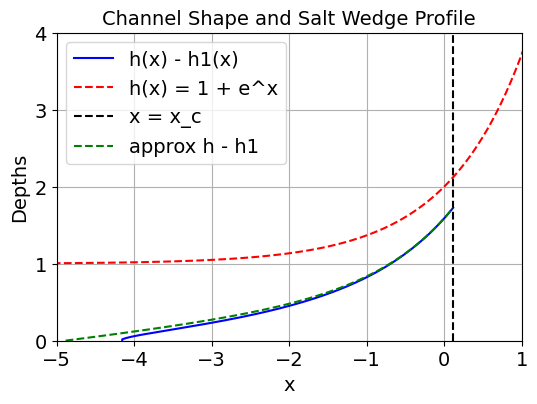

In [ ]:
## h1 ODE integration with perturbed B.C.: epsilon = 10^(-6)
## l against F

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def ode_system(x, h1, F, S, C):
    """
    Right-hand side of the ODE:
      ( (F^2)/(h1^3) - 1 ) * dh1/dx = (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx]
    => dh1/dx = { (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx] } / { (F^2)/(h1^3) - 1 }

    x   : spatial position
    h1  : the unknown function h1(x)
    F   : Froude number
    S   : slope parameter
    C   : given constant
    """
    h = channel_height(x)
    dhdx_val = dhdx(x)

    numerator = (F**2 / h1**3) * (1 + C * h / (h - h1)) - (S + dhdx_val)
    denominator = (F**2 / h1**3) - 1.0

    # Avoid dividing by zero in practice, so handle carefully if the solution is near the singularity.
    return numerator / denominator

def event_h1_equals_h(x, y, F, S, C):
    h = channel_height(x)
    return y[0] - (h - 1e-6)
evt = lambda x, y: event_h1_equals_h(x, y, F, S, C)
evt.terminal  = True
evt.direction = 0
# We want the solver to stop when h1 == h:
# event_h1_equals_h.terminal = True   # Stop integration
# event_h1_equals_h.direction = 0     # h1 reaches h from below

def solve_h1(F, S, C,
             x_end=-1000):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """
    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    # print("x_c_plus = ", x_c_plus)
    # print("x_c_minus = ", x_c_minus)
    h_c             = channel_height(x_c_plus)          # h(x_c)
    h_c_prime       = dhdx(x_c_plus)         # dh/dx at x_c
    h_c_double_prime= d2hdx2(x_c_plus)        # d²h/dx² at x_c
    k = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")
    # print("k (plus branch)  =", k)
    h1_boundary = F**(2.0/3.0) + 1e-6 * k
    # print("h1_boundary = ", h1_boundary)
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]
    x_start = x_c_plus - 1e-6
    # print("x_start = ", x_start)
    h_boundary = channel_height(x_start)
    # print("h_boundary = ", h_boundary)

    if h1_boundary >= h_boundary:
        print("h1_boundary >= h_boundary: no intrusion")
        return None, None, None
    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    else:
        def rhs(x, y, F, S, C):
            # compute the scalar derivative
            dh1dx = ode_system(x, y[0], F, S, C)
            # return it as a 1‐element list/array
            return [dh1dx]

        sol = solve_ivp(
            fun=lambda xx, yy: rhs(xx, yy, F, S, C),
            t_span=(x_start, x_end),
            y0=[h1_boundary],
            method='Radau',           # <-- stiff solver
            max_step=1e-2,            # control step size near singularity
            rtol=1e-6, atol=1e-8,
            events=evt,
            dense_output=True,  # so we can evaluate anywhere
        )

        # Check if the event was triggered:
        if sol.t_events[0].size > 0:
            x_stop  = sol.t_events[0][0]           # precise location
            h1_stop = sol.y_events[0][0, 0]        # h1 there (already stored)
        else:
          # No event triggered => h1 might never equal h within x_start..x_end
            x_stop = None # unbounded intrusion if h1 never reaches h
            h1_stop = None

        return sol, x_stop, h1_stop

def example_single_solution_plot():
    """
    Example of solving and plotting h1(x) vs x for a single set of parameters.
    Also prints the computed l = -x_stop.
    """
    F = 0.25
    S = 0.0
    C = 0.1

    sol, x_stop, h1_stop = solve_h1(F, S, C)
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    if x_stop is not None:
        l_val = x_c_plus - x_stop
        print(f"Solution found up to x = {x_stop:.6f} => l = {l_val:.6f}")
    else:
        print("No crossing event found where h1 = h in the interval.")


    # Plot h1 vs x along the solution
    plt.figure(figsize=(6,4))
    x_start = x_c_plus - 1e-6
    x_vals = np.linspace(x_start, -10, 200)
    if sol is not None:
        h1_plot = sol.sol(x_vals)[0]
        # plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
        plt.plot(x_vals, channel_height(x_vals) - h1_plot, 'b-', label='h(x) - h1(x)')

    # Also plot the channel shape h(x) for reference
    x_vals1 = np.linspace(2, -10, 200)
    plt.plot(x_vals1, channel_height(x_vals1), 'r--', label='h(x) = 1 + e^x')
    plt.axvline(x=x_c_plus, color='k', linestyle='--', label='x = x_c')

    # Plotting the approx (h-h1) to check if calculated k is accurate
    h_c             = channel_height(x_c_plus)          # h(x_c)
    h_c_prime       = dhdx(x_c_plus)         # dh/dx at x_c
    h_c_double_prime= d2hdx2(x_c_plus)        # d²h/dx² at x_c
    k = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")

    def approxh_h1(x):
        return np.exp(x) + k*x + (1 - F**(2/3) - k * x_c_plus)
    x_vals2 = np.linspace(x_c_plus - 5, x_c_plus, 50)
    plt.plot(x_vals2, approxh_h1(x_vals2) , 'g--', label='approx h - h1')

    # Plotting format
    plt.xlim(left = -5, right = 1)
    plt.ylim(bottom= 0, top = 4)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('x', fontsize =14)
    plt.ylabel('Depths', fontsize =14)
    plt.title(f'Channel Shape and Salt Wedge Profile', fontsize =14)
    plt.legend(fontsize =14)
    plt.grid(True)
    plt.show()

def sweep_F_values():
    """
    Example of sweeping over a range of F values and finding the corresponding l.
    Plots l against F.
    """
    F_values = np.linspace(0.01, 50, 100)
    S = 0.0
    C = 0.1

    L_values = []
    for F in F_values:
        x_c_plus, x_c_minus = compute_x_c(F, S, C)
        sol, x_stop, h1_stop = solve_h1(F, S, C)
        if x_stop is not None:
            L_values.append(x_c_plus - x_stop)
        else:
            # If no crossing found, store NaN or some sentinel
            L_values.append(np.nan)

    # Plot L vs F
    plt.figure(figsize=(6,4))
    plt.plot(F_values, L_values, '-', label='l vs F')
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('F', fontsize = 14)
    plt.ylabel('l', fontsize = 14)
    plt.title(f'l vs F (S={S}, C={C})', fontsize = 14)
    plt.grid(True)
    plt.legend()
    # plt.ylim(bottom=-0.01, top = 0.01)
    plt.show()

    # Plot L vs F in loglog scale
    plt.figure(figsize=(6,4))
    plt.loglog(F_values, L_values, '-', label='l vs F in log-log scale')
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('F', fontsize = 14)
    plt.ylabel('l', fontsize = 14)
    plt.xlim(left = 0.25, right = 50)
    plt.grid(True)
    # plt.legend()
    plt.title(f'l vs F (S={S}, C={C}) in log-log scale', fontsize = 14)

if __name__ == "__main__":
    # 1) Solve once for a single set of parameters and plot h1(x) vs x
    example_single_solution_plot()

    # 2) Sweep over F and plot l(F)
    # sweep_F_values()

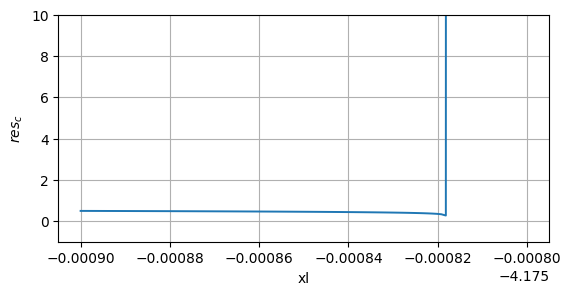

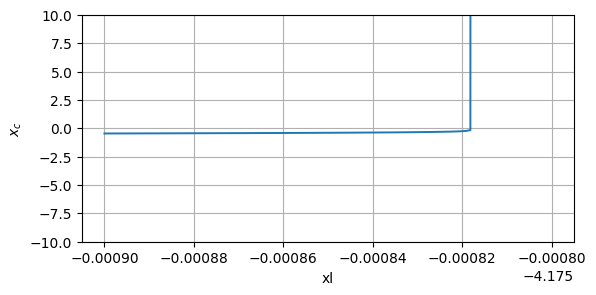

discrete minimum  R_min = 2.712107e-01  at  x_l = -4.175818


In [ ]:
## Shooting Method Trial

from scipy.integrate import solve_ivp
from scipy.optimize  import brentq
import numpy as np
import matplotlib.pyplot as plt

EPS = 1e-6              # small offset to avoid h1 = h exactly

def channel_height(x):
    """
    Prescribed channel shape h(x) = 1 + e^x.
    Valid for x in (-∞, 0].
    """
    return 1.0 + np.exp(x)

def dhdx(x):
    """
    Derivative of h(x) with respect to x.
    For h(x) = 1 + e^x, dh/dx = e^x.
    """
    return np.exp(x)

def d2hdx2(x):
    """
    Derivative of h(x) with respect to x.
    For h(x) = 1 + e^x, dh/dx = e^x.
    """
    return np.exp(x)

def ode_numerator(x, h1, F, S, C):
    h        = channel_height(x)
    dhdx_val = dhdx(x)
    return (F**2 / h1**3) * (1 + C * h / (h - h1)) - (S + dhdx_val)

def residual_at_xc(x_l, F, S, C, *, verbose=False):
    """
    Start at x_l with h1 = h - EPS, integrate forward until h1 = F^(2/3),
    return the numerator of the ODE evaluated at that event point.
    """
    # initial condition just below h to avoid singularity
    h_l    = channel_height(x_l + EPS)
    y0     = [h_l - EPS]

    # event (alternative)
    # def evt(x, y):
        # h1 = y[0]
    # return delta(max(q1, EPS_Q), np.clip(h1, EPS_H, h-EPS_H), h, s1) - DEN_TOL
        # delta  = F**2/h1**3 - 1
        # return delta + EPS

    # event: stop when h1 hits F^(2/3)
    h1_target = F**(2/3) + EPS
    def evt(xx, yy):
        return yy[0] - h1_target

    evt.terminal  = True
    evt.direction = 0

    # integrate
    sol = solve_ivp(
        fun=lambda xx, yy: [ode_system(xx, yy[0], F, S, C)],
        t_span=(x_l + EPS, 10.0),
        y0=y0,
        events=evt,
        method="Radau",
        max_step=1e-2,
        atol=1e-10, rtol=1e-8,
    )

    # if event did not trigger, return large residual and xc
    if sol.t_events[0].size == 0:
        return 1e3, 1e3

    # point where h1 = F^(2/3)  →  this is x_c
    x_c  = sol.t_events[0][0]
    # h1_c = h1_target             # by construction
    h1_c = F**(2/3)
    # h1_c = sol.y_events[0][0, 0]

    resid = ode_numerator(x_c, h1_c, F, S, C)

    if verbose:
        return resid, x_c, sol
    return resid, x_c

# root‐finder
def find_intrusion_length(F=0.25, S=0.0, C=0.1,
                          x_left=-300.0, x_right=-1.0, n_scan=300):
    """
    1. Scan residual(x_l) over [x_left, x_right] to locate a sign change.
    2. Use brentq to find the root: residual(x_l*) = 0.
    3. Return x_l*, x_c, l = x_c – x_l*, and data for plotting.
    """
    # coarse scan
    xls, res = [], []
    for xl in np.linspace(x_left, x_right, n_scan):
        try:
            r = residual_at_xc(xl, F, S, C)
            xls.append(xl); res.append(r)
        except RuntimeError:
            xls.append(xl); res.append(np.nan)

    xls = np.array(xls); res = np.array(res)

    # locate first sign change among valid residuals
    valid = ~np.isnan(res)
    idx   = np.where(valid[:-1] & valid[1:] &
                     (np.sign(res[:-1])*np.sign(res[1:]) < 0))[0]
    if idx.size == 0:
        raise RuntimeError("No sign change found – widen the bracket.")

    a, b = xls[idx[0]], xls[idx[0]+1]

    # root solver
    x_l_star = brentq(lambda xl: residual_at_xc(xl, F, S, C), a, b, xtol=1e-8)

    # integrate once more to get x_c and trajectory
    resid, x_c, sol = residual_at_xc(x_l_star, F, S, C, verbose=True)

    l_val = x_c - x_l_star              # intrusion length

    return x_l_star, x_c, l_val, (xls, res), sol

# demo and plot
def demo_shooting():
    F, S, C = 0.25, 0.0, 0.1
    # x_l_star, x_c, l_val, (xls, res), _ = find_intrusion_length(F, S, C)

    # print(f"x_l*   = {x_l_star:.6f}")
    # print(f"x_c    = {x_c:.6f}")
    # print(f"l      = {l_val:.6f}")

    # xspace = np.linspace(-10,-2,100)
    xspace = np.linspace(-4.1759, -4.1758, 100)
    res_c = []
    x_c = []
    for xl in xspace:
        res_ci, x_ci= residual_at_xc(xl, F, S, C, verbose=False)
        res_c.append(res_ci)
        x_c.append(x_ci)

    # plot res_c against x_l
    plt.figure(figsize=(6,3))
    plt.plot(xspace, res_c, lw=1.4, label=r"$E_c(x_l)$")
    plt.xlabel("xl")
    plt.ylabel(r"$res_c$")
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(-1, 10)
    plt.show()

    # plot x_c against x_l
    plt.figure(figsize=(6,3))
    plt.plot(xspace, x_c, lw=1.4, label=r"$x_c(x_l)$")
    plt.xlabel("xl")
    plt.ylabel(r"$x_c$")
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(-10,10)
    plt.show()

    # Since no sign change was observed, we ask shooting to find the minimum residual point
    # instead of the zero residual point for the correct xl
    res_c = np.asarray(res_c)
    # mask out the NaNs and absurdly large values from the spike
    mask        = np.isfinite(res_c) & (np.abs(res_c) < 1e3)

    idx_min     = np.argmin(res_c[mask])            # index in the masked array
    xl_min      = xspace[mask][idx_min]              # x_l at the minimum
    res_min     = res_c[mask][idx_min]              # minimum residual

    print(f"discrete minimum  R_min = {res_min:.6e}  at  x_l = {xl_min:.6f}")


if __name__ == "__main__":
    # your previous demos …
    # example_single_solution_plot()
    # sweep_F_values()

    # new shooting method
    demo_shooting()


h1_boundary >= h_boundary: no intrusion
No crossing event found where h1 = h in the interval.


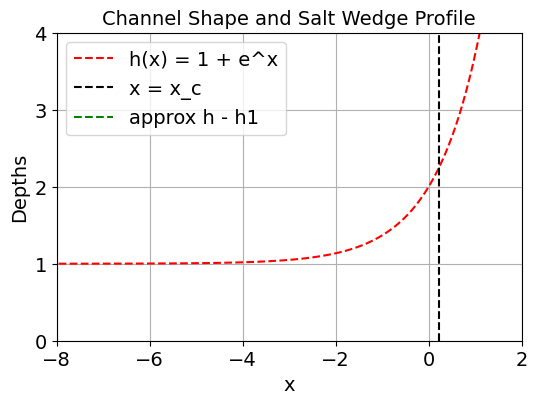

h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion
h1_boundary >= h_boundary: no intrusion


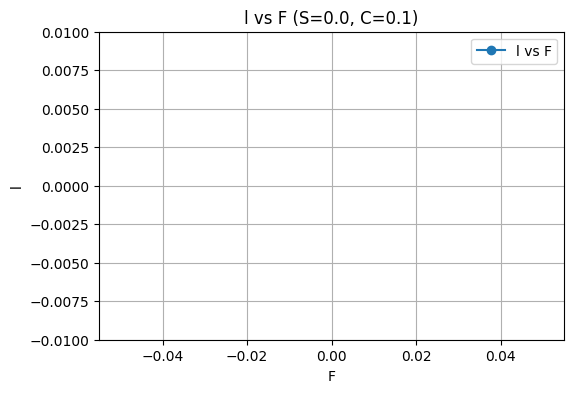

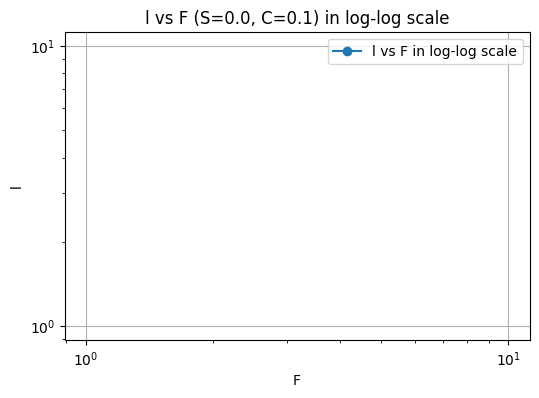

In [ ]:
## h1 ODE integration with perturbed B.C.: epsilon = 10^(-6)
## l against F
## Trial with x_c_minus
## Conclusion: the x_c_minuns is not physical as it means no intrusion for all values of F

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def ode_system(x, h1, F, S, C):
    """
    Right-hand side of the ODE:
      ( (F^2)/(h1^3) - 1 ) * dh1/dx = (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx]
    => dh1/dx = { (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx] } / { (F^2)/(h1^3) - 1 }

    x   : spatial position
    h1  : the unknown function h1(x)
    F   : Froude number
    S   : slope parameter
    C   : given constant
    """
    h = channel_height(x)
    dhdx_val = dhdx(x)

    numerator = (F**2 / h1**3) * (1 + C * h / (h - h1)) - (S + dhdx_val)
    denominator = (F**2 / h1**3) - 1.0

    # Avoid dividing by zero in practice, so handle carefully if the solution is near the singularity.
    return numerator / denominator

def event_h1_equals_h(x, y, F, S, C):
    h = channel_height(x)
    return y[0] - (h - 1e-6)
evt = lambda x, y: event_h1_equals_h(x, y, F, S, C)
evt.terminal  = True
evt.direction = 0
# We want the solver to stop when h1 == h:
# event_h1_equals_h.terminal = True   # Stop integration
# event_h1_equals_h.direction = 0     # h1 reaches h from below

def solve_h1(F, S, C,
             x_end=-1000):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """
    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    # print("x_c_plus = ", x_c_plus)
    # print("x_c_minus = ", x_c_minus)
    h_c             = channel_height(x_c_minus)          # h(x_c)
    h_c_prime       = dhdx(x_c_minus)         # dh/dx at x_c
    h_c_double_prime= d2hdx2(x_c_minus)        # d²h/dx² at x_c
    k = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")
    # print("k (plus branch)  =", k)
    h1_boundary = F**(2.0/3.0) + 1e-6 * k
    # print("h1_boundary = ", h1_boundary)
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]
    x_start = x_c_minus - 1e-6
    # print("x_start = ", x_start)
    h_boundary = channel_height(x_start)
    # print("h_boundary = ", h_boundary)

    if h1_boundary >= h_boundary:
        print("h1_boundary >= h_boundary: no intrusion")
        return None, None, None
    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    else:
        def rhs(x, y, F, S, C):
            # compute the scalar derivative
            dh1dx = ode_system(x, y[0], F, S, C)
            # return it as a 1‐element list/array
            return [dh1dx]

        sol = solve_ivp(
            fun=lambda xx, yy: rhs(xx, yy, F, S, C),
            t_span=(x_start, x_end),
            y0=[h1_boundary],
            method='Radau',           # <-- stiff solver
            max_step=1e-2,            # control step size near singularity
            rtol=1e-6, atol=1e-8,
            events=evt,
            dense_output=True,  # so we can evaluate anywhere
        )

      # Check if the event was triggered:
        if sol.t_events[0].size > 0:
            x_stop  = sol.t_events[0][0]           # precise location
            h1_stop = sol.y_events[0][0, 0]        # h1 there (already stored)
        else:
          # No event triggered => h1 might never equal h within x_start..x_end
            x_stop = None # unbounded intrusion if h1 never reaches h
            h1_stop = None

        return sol, x_stop, h1_stop

def example_single_solution_plot():
    """
    Example of solving and plotting h1(x) vs x for a single set of parameters.
    Also prints the computed l = -x_stop.
    """
    F = 1.5
    S = 0.0
    C = 0.1

    sol, x_stop, h1_stop = solve_h1(F, S, C)
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    if x_stop is not None:
        l_val = x_c_minus - x_stop
        print(f"Solution found up to x = {x_stop:.4f} => l = {l_val:.4f}")
    else:
        print("No crossing event found where h1 = h in the interval.")


    # Plot h1 vs x along the solution
    plt.figure(figsize=(6,4))
    x_start = x_c_minus - 1e-6
    x_vals = np.linspace(x_start, -10, 200)
    if sol is not None:
        h1_plot = sol.sol(x_vals)[0]
        # plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
        plt.plot(x_vals, channel_height(x_vals) - h1_plot, 'b-', label='h(x) - h1(x)')

    # Also plot the channel shape h(x) for reference
    x_vals1 = np.linspace(2, -10, 200)
    plt.plot(x_vals1, channel_height(x_vals1), 'r--', label='h(x) = 1 + e^x')
    plt.axvline(x=x_c_plus, color='k', linestyle='--', label='x = x_c')

    # Plotting the approx (h-h1) to check if calculated k is accurate
    h_c             = channel_height(x_c_minus)          # h(x_c)
    h_c_prime       = dhdx(x_c_minus)         # dh/dx at x_c
    h_c_double_prime= d2hdx2(x_c_minus)        # d²h/dx² at x_c
    k = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")

    def approxh_h1(x):
        return np.exp(x) + k*x + (1 - F**(2/3) - k * x_c_minus)
    x_vals2 = np.linspace(x_c_minus - 5, x_c_minus, 50)
    plt.plot(x_vals2, approxh_h1(x_vals2) , 'g--', label='approx h - h1')

    # Plotting format
    plt.xlim(left = -8, right = 2)
    plt.ylim(bottom= 0, top = 4)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('x', fontsize =14)
    plt.ylabel('Depths', fontsize =14)
    plt.title(f'Channel Shape and Salt Wedge Profile', fontsize =14)
    plt.legend(fontsize =14)
    plt.grid(True)
    plt.show()

def sweep_F_values():
    """
    Example of sweeping over a range of F values and finding the corresponding l.
    Plots l against F.
    """
    F_values = np.linspace(1.5, 50, 50)
    S = 0.0
    C = 0.1

    L_values = []
    for F in F_values:
        x_c_plus, x_c_minus = compute_x_c(F, S, C)
        sol, x_stop, h1_stop = solve_h1(F, S, C)
        if x_stop is not None:
            L_values.append(x_c_minus - x_stop)
        else:
            # If no crossing found, store NaN or some sentinel
            L_values.append(np.nan)

    # Plot L vs F
    plt.figure(figsize=(6,4))
    plt.plot(F_values, L_values, 'o-', label='l vs F')
    plt.xlabel('F')
    plt.ylabel('l')
    plt.title(f'l vs F (S={S}, C={C})')
    plt.grid(True)
    plt.legend()
    plt.ylim(bottom=-0.01, top = 0.01)
    plt.show()

    # Plot L vs F in loglog scale
    plt.figure(figsize=(6,4))
    plt.loglog(F_values, L_values, 'o-', label='l vs F in log-log scale')
    plt.xlabel('F')
    plt.ylabel('l')
    plt.grid(True)
    plt.legend()
    plt.title(f'l vs F (S={S}, C={C}) in log-log scale')

if __name__ == "__main__":
    # 1) Solve once for a single set of parameters and plot h1(x) vs x
    example_single_solution_plot()

    # 2) Sweep over F and plot l(F)
    sweep_F_values()

No crossing event found where h1 = h in the interval.


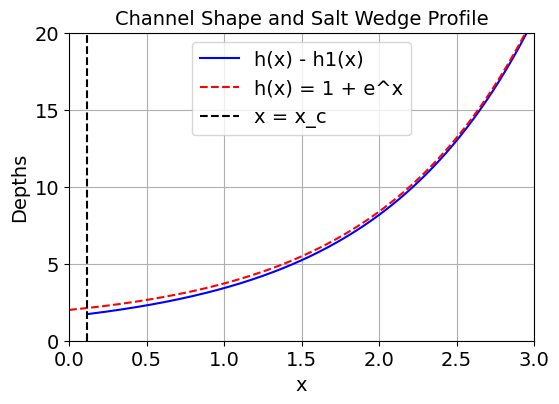

In [ ]:
## h1 ODE integration with perturbed B.C.: epsilon = 10^(-3)
## fresh water plume

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def ode_system(x, h1, F, S, C):
    """
    Right-hand side of the ODE:
      ( (F^2)/(h1^3) - 1 ) * dh1/dx = (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx]
    => dh1/dx = { (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx] } / { (F^2)/(h1^3) - 1 }

    x   : spatial position
    h1  : the unknown function h1(x)
    F   : Froude number
    S   : slope parameter
    C   : given constant
    """
    h = channel_height(x)
    dhdx_val = dhdx(x)

    numerator = (F**2 / h1**3) * (1 + C * h / (h - h1)) - (S + dhdx_val)
    denominator = (F**2 / h1**3) - 1.0

    # Avoid dividing by zero in practice, so handle carefully if the solution is near the singularity.
    return numerator / denominator

def event_h1_equals_h(x, y, F, S, C):
    """
    Event function for solve_ivp to stop when h1(x) == h(x).
    We define the zero-crossing to be h1 - h = 0.
    """
    h = channel_height(x)
    return y[0] - h

# We want the solver to stop when h1 == h:
event_h1_equals_h.terminal = True   # Stop integration
event_h1_equals_h.direction = 0     # Detect all zero-crossings

def solve_h1(F, S, C,
             x_end=10):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """

    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    h_c             = channel_height(x_c_plus)          # h(x_c)
    h_c_prime       = dhdx(x_c_plus)         # dh/dx at x_c
    h_c_double_prime= d2hdx2(x_c_plus)        # d²h/dx² at x_c
    k = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")
    h1_boundary = F**(2.0/3.0) - 1e-3 * k

    # Optionally shift the initial h1 by a tiny offset if desired,
    # though you can also just keep it exactly h1_boundary.
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]
    x_start = x_c_plus + 1e-3

    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    sol = solve_ivp(
        fun=lambda xx, yy: ode_system(xx, yy[0], F, S, C),
        t_span=(x_start, x_end),
        y0=y0,
        events=lambda xx, yy: event_h1_equals_h(xx, yy, F, S, C),
        dense_output=True,  # so we can evaluate anywhere
        max_step=1e-3       # limit step size if needed
    )

    # Check if the event was triggered:
    if sol.t_events[0].size > 0:
        x_stop = sol.t_events[0][0]
        # Evaluate h1 at x_stop:
        h1_stop = sol.sol(x_stop)[0]
    else:
        # No event triggered => h1 might never equal h within x_start..x_end
        x_stop = None
        h1_stop = None

    return sol, x_stop, h1_stop

def example_single_solution_plot():
    """
    Example of solving and plotting h1(x) vs x for a single set of parameters.
    Also prints the computed l = -x_stop.
    """
    F = 0.25
    S = 0.0
    C = 0.1

    sol, x_stop, h1_stop = solve_h1(F, S, C)
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    if x_stop is not None:
        l_val = x_c_plus - x_stop
        print(f"Solution found up to x = {x_stop:.4f} => l = {l_val:.4f}")
    else:
        print("No crossing event found where h1 = h in the interval.")


    # Plot h1 vs x along the solution
    plt.figure(figsize=(6,4))
    x_start = x_c_plus + 1e-3
    x_vals = np.linspace(x_start, 3, 200)
    h1_plot = sol.sol(x_vals)[0]
    # plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
    plt.plot(x_vals, channel_height(x_vals) - h1_plot, 'b-', label='h(x) - h1(x)')
    # Also plot the channel shape h(x) for reference
    x_vals1 = np.linspace(0, 3, 200)
    plt.plot(x_vals1, channel_height(x_vals1), 'r--', label='h(x) = 1 + e^x')
    plt.axvline(x=x_c_plus, color='k', linestyle='--', label='x = x_c')
    plt.xlim(left = 0, right = 3)
    plt.ylim(bottom = 0, top = 20)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('x', fontsize =14)
    plt.ylabel('Depths', fontsize =14)
    plt.title(f'Channel Shape and Salt Wedge Profile', fontsize =14)
    plt.legend(fontsize =14)
    plt.grid(True)
    plt.show()

def sweep_F_values():
    """
    Example of sweeping over a range of F values and finding the corresponding l.
    Plots l against F.
    """
    F_values = np.linspace(0.01, 10, 10)  # for example
    S = 0.0
    C = 0.1

    L_values = []
    for F in F_values:
        x_c_plus, x_c_minus = compute_x_c(F, S, C)
        sol, x_stop, h1_stop = solve_h1(F, S, C)
        if x_stop is not None:
            L_values.append(x_c_plus - x_stop)
        else:
            # If no crossing found, store NaN or some sentinel
            L_values.append(np.nan)

    plt.figure(figsize=(6,4))
    plt.plot(F_values, L_values, 'o-', label='l vs F')
    plt.xlabel('F')
    plt.ylabel('l')
    plt.title(f'l vs F (S={S}, C={C})')
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # 1) Solve once for a single set of parameters and plot h1(x) vs x
    example_single_solution_plot()

    # 2) Sweep over F and plot l(F)
    # sweep_F_values()

Solution found up to x = -4.1757 => l = 4.2917


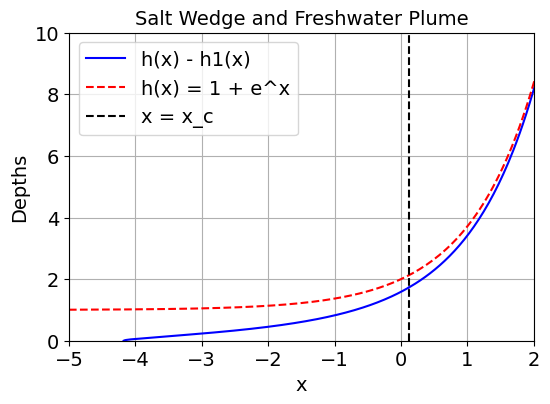

In [ ]:
## h1 ODE integration with perturbed B.C.: epsilon = 10^(-3)
## Salt Wedge and Fresh Water Plume Combined

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def ode_system(x, h1, F, S, C):
    """
    Right-hand side of the ODE:
      ( (F^2)/(h1^3) - 1 ) * dh1/dx = (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx]
    => dh1/dx = { (F^2)/(h1^3) [1 + c*(h/(h - h1)) ] - [S + dh/dx] } / { (F^2)/(h1^3) - 1 }

    x   : spatial position
    h1  : the unknown function h1(x)
    F   : Froude number
    S   : slope parameter
    C   : given constant
    """
    h = channel_height(x)
    dhdx_val = dhdx(x)

    numerator = (F**2 / h1**3) * (1 + C * h / (h - h1)) - (S + dhdx_val)
    denominator = (F**2 / h1**3) - 1.0

    # Avoid dividing by zero in practice, so handle carefully if the solution is near the singularity.
    return numerator / denominator

def event_h1_equals_h(x, y, F, S, C):
    """
    Event function for solve_ivp to stop when h1(x) == h(x).
    We define the zero-crossing to be h1 - h = 0.
    """
    h = channel_height(x)
    return y[0] - h

# We want the solver to stop when h1 == h:
event_h1_equals_h.terminal = True   # Stop integration
event_h1_equals_h.direction = 0     # Detect all zero-crossings

def solve_h1(F, S, C,
             x_end=-20):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """

    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    h_c             = channel_height(x_c_plus)          # h(x_c)
    h_c_prime       = dhdx(x_c_plus)         # dh/dx at x_c
    h_c_double_prime= d2hdx2(x_c_plus)        # d²h/dx² at x_c
    k = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")
    h1_boundary = F**(2.0/3.0) + 1e-3 * k

    # Optionally shift the initial h1 by a tiny offset if desired,
    # though you can also just keep it exactly h1_boundary.
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]
    x_start = x_c_plus - 1e-3

    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    sol = solve_ivp(
        fun=lambda xx, yy: ode_system(xx, yy[0], F, S, C),
        t_span=(x_start, x_end),
        y0=y0,
        events=lambda xx, yy: event_h1_equals_h(xx, yy, F, S, C),
        dense_output=True,  # so we can evaluate anywhere
        max_step=1e-3       # limit step size if needed
    )

    # Check if the event was triggered:
    if sol.t_events[0].size > 0:
        x_stop = sol.t_events[0][0]
        # Evaluate h1 at x_stop:
        h1_stop = sol.sol(x_stop)[0]
    else:
        # No event triggered => h1 might never equal h within x_start..x_end
        x_stop = None
        h1_stop = None

    return sol, x_stop, h1_stop

## h1 ODE integration with perturbed B.C.: epsilon = 10^(-3)
## fresh water plume

def solve_h1_1(F, S, C,
             x_end=10):
    """
    Solve the ODE from x_start down to x_end (negative direction),
    with an initial guess for h1 near F^(2/3).
    Once h1 = h is reached, the solver stops by the event.

    Returns:
      sol       : the ODE solution object from solve_ivp
      x_stop    : where the event h1-h=0 occurs (i.e., x = -l)
      h1_stop   : h1 at that point (should equal h)
    """

    # The exact boundary condition is h1(0) = F^(2/3).
    # To avoid singularity, we start from x_start < 0 with h1 ~ F^(2/3).
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    h_c             = channel_height(x_c_plus)          # h(x_c)
    h_c_prime       = dhdx(x_c_plus)         # dh/dx at x_c
    h_c_double_prime= d2hdx2(x_c_plus)        # d²h/dx² at x_c
    k = k_initial(F, C, h_c, h_c_prime, h_c_double_prime, "plus")
    h1_boundary = F**(2.0/3.0) - 1e-3 * k

    # Optionally shift the initial h1 by a tiny offset if desired,
    # though you can also just keep it exactly h1_boundary.
    y0 = [h1_boundary]  # or [h1_boundary + h1_start_offset]
    x_start = x_c_plus + 1e-3

    # We'll integrate from x_start to x_end. Because x_start > x_end,
    # the solver automatically goes "backwards" in x.
    sol1 = solve_ivp(
        fun=lambda xx, yy: ode_system(xx, yy[0], F, S, C),
        t_span=(x_start, x_end),
        y0=y0,
        events=lambda xx, yy: event_h1_equals_h(xx, yy, F, S, C),
        dense_output=True,  # so we can evaluate anywhere
        max_step=1e-3       # limit step size if needed
    )

    # Check if the event was triggered:
    if sol1.t_events[0].size > 0:
        x_stop1 = sol1.t_events[0][0]
        # Evaluate h1 at x_stop:
        h1_stop1 = sol1.sol(x_stop1)[0]
    else:
        # No event triggered => h1 might never equal h within x_start..x_end
        x_stop1 = None
        h1_stop1 = None

    return sol1, x_stop1, h1_stop1

def example_single_solution_plot():
    """
    Example of solving and plotting h1(x) vs x for a single set of parameters.
    Also prints the computed l = -x_stop.
    """
    F = 0.25
    S = 0.0
    C = 0.1

    sol, x_stop, h1_stop = solve_h1(F, S, C)
    sol1, x_stop1, h1_stop1 = solve_h1_1(F, S, C)
    x_c_plus, x_c_minus = compute_x_c(F, S, C)
    if x_stop is not None:
        l_val = x_c_plus - x_stop
        print(f"Solution found up to x = {x_stop:.4f} => l = {l_val:.4f}")
    else:
        print("No crossing event found where h1 = h in the interval.")

    # Plot h1 vs x along the solution
    plt.figure(figsize=(6,4))
    x_start = x_c_plus - 1e-3
    x_vals = np.linspace(x_start, x_stop, 200)
    h1_plot = sol.sol(x_vals)[0]
    # plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
    plt.plot(x_vals, channel_height(x_vals) - h1_plot, 'b-', label='h(x) - h1(x)')

    x_start1 = x_c_plus + 1e-3
    x_vals1 = np.linspace(x_start1, 5, 200)
    h1_plot1 = sol1.sol(x_vals1)[0]
    # plt.plot(x_vals, h1_plot, 'b-', label='h1(x)')
    plt.plot(x_vals1, channel_height(x_vals1) - h1_plot1, 'b-')
    # Also plot the channel shape h(x) for reference
    x_vals2 = np.linspace(-5, 5, 200)
    plt.plot(x_vals2, channel_height(x_vals2), 'r--', label='h(x) = 1 + e^x')
    plt.axvline(x=x_c_plus, color='k', linestyle='--', label='x = x_c')

    plt.xlim(left = -5, right = 2)
    plt.ylim(bottom = 0, top = 10)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('x', fontsize =14)
    plt.ylabel('Depths', fontsize =14)
    plt.title(f'Salt Wedge and Freshwater Plume', fontsize =14)
    plt.legend(fontsize =14)
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    # 1) Solve once for a single set of parameters and plot h1(x) vs x
    example_single_solution_plot()